# Calcul de la constante de Lifschitz

In [1]:
# importation
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# local
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.main import FBRestNet
from FBResNet.model import MyModel
from FBResNet.posttreat import Export_hyper

### Parametres

In [2]:
exp1 = FBRestNet(experimentation=Physics(2000,50,1,1), nb_blocks=20, noise = 0.05,\
                 folder = './', im_set="Set1",batch_size=[100,1],\
                 lr=1e-3, nb_epochs=[20,1])

### Data set
On entraine sur 300 données et on évalue sur 100.

In [3]:
train_set, val_set = exp1.CreateDataSet()

### Trainings
Entrainement sur 20 époques, learning rate de $10^{-3}$.
On trace la constante de Lipschitz au cours de l' entrainement.

epoch :  0  -----  validation :  0.006138916508379308
epoch :  1  -----  validation :  0.006132975305345925
epoch :  2  -----  validation :  0.006118734289581577
epoch :  3  -----  validation :  0.006114595231007446
epoch :  4  -----  validation :  0.006106714619267167
epoch :  5  -----  validation :  0.006094208516349847
epoch :  6  -----  validation :  0.0060869060054590755
epoch :  7  -----  validation :  0.006069977915930477
epoch :  8  -----  validation :  0.00605389802843671
epoch :  9  -----  validation :  0.006036582494606123
epoch :  10  -----  validation :  0.006016287176559369
epoch :  11  -----  validation :  0.006007379788736051
epoch :  12  -----  validation :  0.005991074863369718
epoch :  13  -----  validation :  0.005983393921545057
epoch :  14  -----  validation :  0.005976520189450997
epoch :  15  -----  validation :  0.005968195848364496
epoch :  16  -----  validation :  0.005962290614137821
epoch :  17  -----  validation :  0.005945630343348691
epoch :  18  -----  

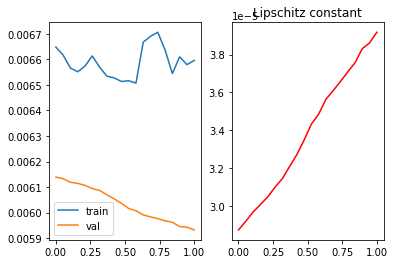

Final Lipschitz constant =  3.918325088761834e-05


In [4]:
exp1.train(train_set,val_set,save_model=True)

### Affichage de résultats

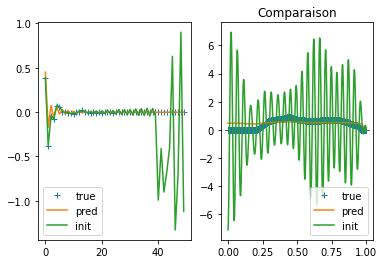

Erreur relative :  0.23635977913367107


In [5]:
l_i, l_t, l_p = exp1.test(val_set)

### Affichage paramètres

In [6]:
k = np.linspace(1,20,20)
gamma =np.zeros(20)
reg   =np.zeros(20)
mu    =np.zeros(20)
for i in range(0,len(exp1.model.Layers)):
    gamma[i] = exp1.model.Layers[i].gamma_reg[0]
    reg[i]   = exp1.model.Layers[i].gamma_reg[1]
    mu[i]    = exp1.model.Layers[i].mu[0]

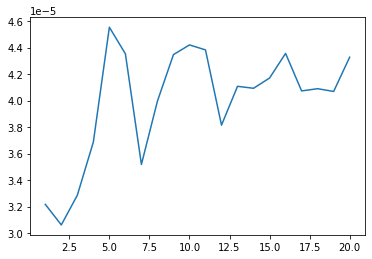

In [7]:
plt.plot(k,gamma)

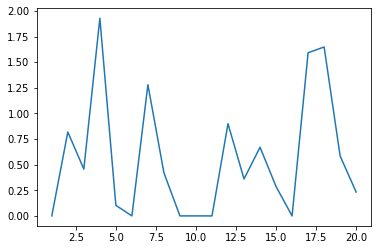

In [8]:
plt.plot(k,reg)

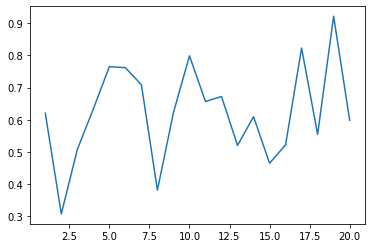

In [9]:
plt.plot(k,mu)

In [10]:
# folder = './Redaction/data'
# Export_hyper(exp1,x_init,x_b,folder)

### REG Parameter

In [11]:
from torch.autograd import Variable
minibatch = iter(val_set)
[y, x] = next(minibatch)            # gets the minibatch
x_true = Variable(x,requires_grad=False)
x_bias = Variable(y,requires_grad=False)

In [12]:
from FBResNet.model import Cnn_reg

In [13]:
exp=Physics(2000,50,1,1)
mycnn = Cnn_reg(exp)

In [14]:
mycnn(x_bias)

tensor([[[0.5979]]], grad_fn=<ViewBackward>)

### Test with gaussian

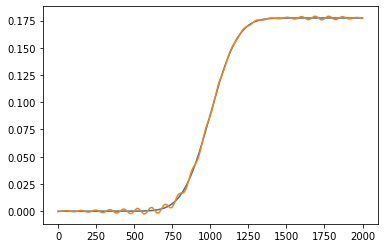

x-xp/x = 0.23725162040089579


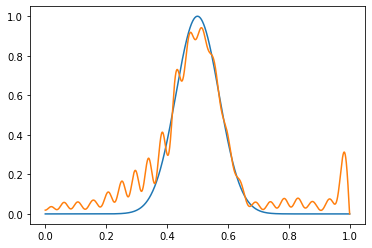

In [15]:
exp1.test_gauss(noise=0.01)

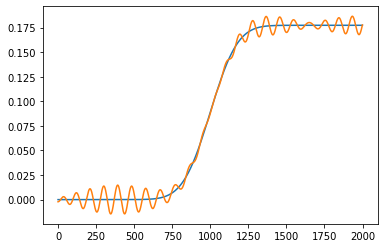

x-xp/x = 0.808572242905128


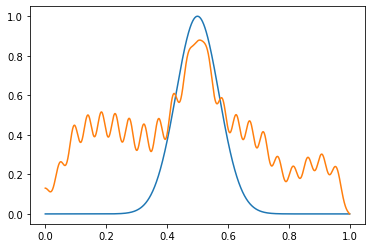

In [16]:
exp1.test_gauss(noise=0.05)

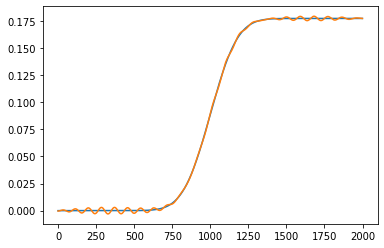

x-xp/x = 0.2601762775368798


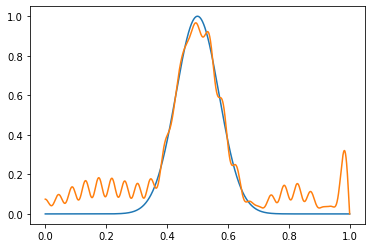

In [17]:
exp1.test_gauss(noise=0.01)

### Lipschitz constant

In [18]:
exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.04928256839194845

In [19]:
exp1.model.Lipschitz(opt1="semi",opt2="entree01")

3.936126486743169e-05

### TEST ON OTHER FUNCTIONS